# Otimização em ação

<center>
Francisco Nogueira Calmon Sobral<BR>
Universidade Estadual de Maringá - PR - Brasil<BR>
ERMAC PR - 07 de Maio de 2025
</center>

Este trabalho foi feito com a ajuda de

  - Anderson Ervino Schwertner
  - Joaquim Gabriel Martins

e foi inteiramente baseado no artigo

> PERALTA, J., ANDRETTA, M., OLIVEIRA, J. **Packing Circles and Irregular Polygons using Separation Lines**. Proceedings of the 7th International Conference on Operations Research and Enterprise Systems (ICORES 2018), 71-77, 2018.

In [12]:
using Pkg

Pkg.activate("../ermacpr25")
Pkg.instantiate()

  Activating project at `~/personal/working/minicurso-empacotamento/ermacpr25`


In [13]:
using Plots, LinearAlgebra, JuMP, Ipopt

In [14]:
include("../ermacpr25/src/ermacpr25.jl")

desenha_solucao_qc (generic function with 1 method)

# Empacotamento de itens irregulares

Para resolver o problema de itens complexos, como triângulos e polígonos não convexos usaremos a seguinte observação:

> Dados dois convexos, existe **uma reta** que os separa

  - Polígonos irregulares serão modelados como a união de convexos (triangularização, por exemplo)
  - Retas variáveis separarão polígonos de objetos distintos

# A modelagem
  
  - Um círculo $i \in \mathcal{C}$ será definido pelas coordenadas do seu centro $(x^C_i, y^C_i)$ e seu raio $r_i$.
  - Um polígono $i \in \mathcal{P}$ será definido pela rotação $\theta_i$ e deslocamento $(x^P_i, y_i^P)$ aplicadas em um **polígono-base** $B_i$
      - O polígono base $B_i$ é formado pela união de $p_i$ polígonos convexos $P^i_1, P^i_2, \dots, P^i_{p_i}$
      - Cada $P^i_j$ convexo é formado por $v^i_j$ vértices $(v^{i, j, k}_x, v^{i, j, k}_y)$
      - Dados $\theta_i$ e $(x^P_i, y_i^P)$, denotaremos por $D_i$ a operação de rotação seguida de deslocamento

In [15]:
P = [
        [ # Poligono 1
            [0.0 1.155; 0.866 0.577; 0.866 -0.577; 0.0 -1.155; -0.866 -0.577; -0.866 0.577;   ]
        ],
        [  # Poligono 2
            [0.0 0.0; 2.0 0.0; 2.0 2.0; 0.0 2.0]
        ], 
        [  # Poligono 3
            [4.0 0.0; 6.0 0.0; 7.0 1.73; 6.0 3.46; 4.0 3.46; 3.0 1.73]
        ],
        [ # Poligono 4
            [8.0 2.0; 10.0 0.0; 11.0 2.0; 9.0 3.0],
            [10.0 0.0; 16.0 3.0; 15.0 4.0; 11.0 2.0]
        ],
        [ # Poligono 5
            [0.0 0.0; 2.0 0.0; 1.5 1.5]
        ],
        [ # Poligono 6
            [0.0 0.0; 2.0 0.0; 4 2; 2.0 2.0],
            [4.0 2.0; 3.0 3.0; 1.0 3.0; 2.0 2.0]
        ]
];

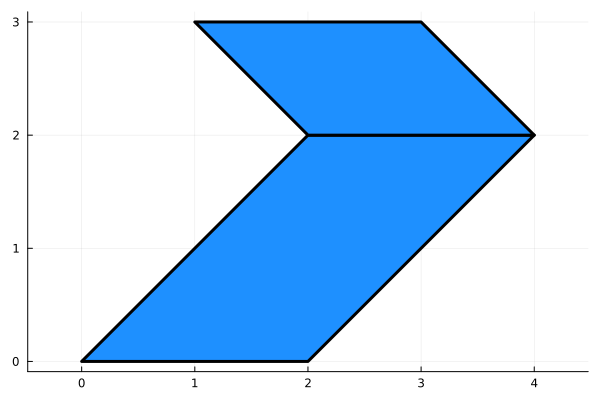

In [16]:
plot(uniao_poligonos(P[6]), c=:dodgerblue, lc=:black, lw=3, label=false, aspect_ratio=true)

In [17]:

"""
    cosseno_model_teste!(model, poligonos, ang, xP, yP)

Cria as expressões para as coordenadas dos polígonos após a rotação e deslocamento.
"""
function cosseno_model_teste!(model, poligonos, ang, xP, yP)
    np = length(poligonos)
    nalpha = length(ang)
    nx = length(xP)
    ny = length(yP)
    nley = Vector{Any}(undef, np)
    nlex = Vector{Any}(undef, np)
    for i = 1:np
        nlex[i] = @NLexpression(model, [n = 1:length(poligonos[i]), h = 1:size(poligonos[i][n])[1]], 
                        poligonos[i][n][h, 1] * cos(ang[i]) - poligonos[i][n][h, 2] * sin(ang[i]) + xP[i])

        nley[i] = @NLexpression(model, [n = 1:length(poligonos[i]), h = 1:size(poligonos[i][n])[1]], 
                        poligonos[i][n][h, 1] * sin(ang[i]) + poligonos[i][n][h, 2] * cos(ang[i]) + yP[i])
    end
    return nlex, nley
end

cosseno_model_teste!

  - Deve haver uma reta separadora para cada par de polinômios convexos que formam os polinômios $i$ e $j$ com  $i, j \in \mathcal{P}$
    $$
    r^P_{i, j, k, l}: \quad y = c^{P}_{i, j, k, l} \cdot x + d^P_{i, j, k, l},
    $$
    com
    $$
    \begin{split}
    c^P_{i, j, k, l} & = \frac{\sin(\alpha_{i, j, k, l})}{\cos(\alpha_{i, j, k, l})} \\
    d^P_{i, j, k, l} & = x^{rP}_{i, j, k, l} + c^{P}_{i, j , k, l} \cdot y^{rP}_{i, j, k, l}
    \end{split}
    $$
    para $k = 1, \dots p_i$ e $l = 1, \dots, p_j$

In [18]:
function cdij!(model, reta, alpha_L, xL, yL)
    nr = length(reta)
    nlerc = Array{Any}(undef, nr)
    nlerd = Array{Any}(undef, nr)
    for i = 1:nr-1
        nlerc[i] = Array{Any}(undef, length(reta[i]))
        nlerd[i] = Array{Any}(undef, length(reta[i]))
        noutrascc = 0
        for j = i+1:nr
            if (reta[j]) != 0
                noutrascc += length(reta[j])
            end
        end
        for h = 1:length(reta[i])
            nlerc[i][h] = Array{Any}(undef, noutrascc)
            nlerd[i][h] = Array{Any}(undef, noutrascc)
            k = 0
            for n = i+1:nr # Fixa o Pol_j
                for l = 1:length(reta[n]) # Seleciona a l-esima comp. convexa do Pol_j
                    k += 1
                    nlerc[i][h][k] = @NLexpression(model, ((reta[i][h][2, 1] - reta[i][h][1, 1]) * sin(alpha_L[i,h,k]) + (reta[i][h][2, 2] - reta[i][h][1, 2]) * cos(alpha_L[i,h,k])) /
                                            ((reta[i][h][2, 1] - reta[i][h][1, 1]) * cos(alpha_L[i,h,k]) + (reta[i][h][1, 2] - reta[i][h][2, 2]) * sin(alpha_L[i,h,k])))
                    nlerd[i][h][k] = @NLexpression(model, yL[i,h,k] - nlerc[i][h][k] * xL[i,h,k])
                end
            end
        end
    end
    return nlerc, nlerd
end

cdij! (generic function with 1 method)

- De maneira análoga, devemos ter uma reta que separa um círculo $i \in \mathcal{C}$ de todos os $k$ polinômios convexos do polígono $j \in \mathcal{P}$
    $$
    r^C_{i, j, k}: \quad y = c^{C}_{i, j, k} \cdot x + d^C_{i, j, k}
    $$

In [19]:
function cdij_circ!(model, reta, alpha_L_circ, xL_circ, yL_circ, raio)
    nr = length(reta)
    nc = length(raio)
    nlerc_circ = Array{Any}(undef, nr)
    nlerd_circ = Array{Any}(undef, nr)
    
    for i = 1:nr
        nlerc_circ[i] = Array{Any}(undef, length(reta[i]))
        nlerd_circ[i] = Array{Any}(undef, length(reta[i]))
        noutrascc = 0
        
        for j = 1:nc
            noutrascc += 1
        end
        
        for h = 1:length(reta[i])
            nlerc_circ[i][h] = Array{Any}(undef, noutrascc)
            nlerd_circ[i][h] = Array{Any}(undef, noutrascc)
            k = 0
            
            for n = 1:nc # Fixa o circ
                k += 1
                nlerc_circ[i][h][k] = @NLexpression(model, ((reta[i][h][2, 1] - reta[i][h][1, 1]) * sin(alpha_L_circ[i,h,k]) + (reta[i][h][2, 2] - reta[i][h][1, 2]) * cos(alpha_L_circ[i,h,k])) /
                                            ((reta[i][h][2, 1] - reta[i][h][1, 1]) * cos(alpha_L_circ[i,h,k]) + (reta[i][h][1, 2] - reta[i][h][2, 2]) * sin(alpha_L_circ[i,h,k])))
                nlerd_circ[i][h][k] = @NLexpression(model, yL_circ[i,h,k] - nlerc_circ[i][h][k] * xL_circ[i,h,k])
            end
        end
    end
    
    return nlerc_circ, nlerd_circ
end

cdij_circ! (generic function with 1 method)

### Alocação

Considerando que o retângulo possui lados $W \times L$ e o vértice inferior esquerdo é a origem

  - Círculos
    $$
    \begin{split}
    r_i \le x^C_i & \le W - r_i \\
    r_i \le y^C_i & \le L - r_i 
    \end{split}
    $$
  - Polígonos
    $$
    \begin{split}
    0 \le x^P_i + \cos(\theta^P_i) v^{i, j, k}_x - \sin(\theta^P_i) v^{i, j, k}_y & \le W \\
    0 \le y^P_i + \sin(\theta^P_i) v^{i, j, k}_x + \cos(\theta^P_i) v^{i, j, k}_y & \le L
    \end{split}
    $$
    para todo $j = 1, \dots, p_i$ e $k = 1, \dots, v^i_j$

In [20]:
function constraints!(model,poligonos,nlex,nley,nlerc,nlerd,l,w)
    for i = 1:length(poligonos)
     nle_x = nlex[i]
     nle_y = nley[i]
     @NLconstraint(model, [n =1:length(poligonos[i]), h =1:size(poligonos[i][n])[1]], nle_x[n,h] >= 0 )
     @NLconstraint(model,[n =1:length(poligonos[i]), h =1:size(poligonos[i][n])[1]],  nle_y[n,h] >= 0  )
     @NLconstraint(model, [n =1:length(poligonos[i]), h =1:size(poligonos[i][n])[1]], nle_x[n,h] <= w )
     @NLconstraint(model,[n =1:length(poligonos[i]), h =1:size(poligonos[i][n])[1]],  nle_y[n,h] <= l )       
    end
end

function contcir!(model,raios,xC,yC,l,w)
    #colocar l e w como variável local
    for i=1:length(xC)
        @NLconstraint(model, 0<= xC[i]- raios[i]  )
        @NLconstraint(model,  0<= yC[i]- raios[i]  )
        @NLconstraint(model,  raios[i]+xC[i] <= w)
        @NLconstraint(model,  raios[i]+yC[i] <= l)
        @NLconstraint(model, xC[i] >= 0)
        @NLconstraint(model, yC[i] >= 0)
    end
     return model
end

contcir! (generic function with 1 method)

### Sobreposição entre círculos

$$
(x^C_i - x^C_j)^2 + (y^C_i - y^C_j)^2 \ge (r_i + r_j)^2
$$

In [21]:
function nsobrecirc!(model,Xc,yC,raios)
    nc = length(raios)
    @NLconstraint(model, [i = 1:nc, j = i + 1:nc],
        (xC[i] - xC[j])^2.0 + (yC[i] - yC[j])^2.0 >= (raios[i] + raios[j])^2.0)
    # for i= 1:length(xC)
    #     for j= i+1:length(xC)
    #         @NLconstraint(model, (xC[i] - xC[j])^2.0 + (yC[i] - yC[j])^2.0 >= (raios[i] + raios[j])^2.0)
    #     end
    # end
    return model
end 

nsobrecirc! (generic function with 1 method)

### Sobreposição entre círculo e polígono

Dado um polígono $i$ e um círculo $j$, temos uma reta separadora $r^C_{i, j, k}$, $k = 1, \dots, p_j$, de forma que
$$
\begin{split}
y^C_i - c^C_{i, j, k} \cdot x^C_i & \le d^C_{i, j, k} \\
\bigg( y^P_i + \sin(\theta^P_i) v^{j, k, l}_x + \cos(\theta^P_i) v^{j, k, l}_y\bigg) - c^C_{i, j, k} \bigg( x^P_i + \cos(\theta^P_i) v^{j, k, l}_x - \sin(\theta^P_i) v^{j, k, l}_y \bigg) & \ge d^C_{i, j, k} \\
\bigg(c^C_{i, j, k} \cdot x^C_i - y^C_i + d^C_{i, j, l}\bigg)^2 - r_i^2 \cdot \bigg((c^C_{i, j, k})^2 + 1\bigg) & \ge 0
\end{split}
$$

In [22]:
function last_re!(model, poligonos, xC, yC, nlerc_circ, nlerd_circ, nlex, nley)
    for i = 1:length(poligonos)
          for h = 1:length(poligonos[i])
                 k = 0
                 for q = 1:length(xC) 
                     k += 1
                     c = nlerc_circ[i][h][k]
                     d = nlerd_circ[i][h][k]
                     @NLconstraint(model, [f = 1:size(poligonos[i][h], 1)],
                        nley[i][h,f] - c*nlex[i][h,f] - d >= 0)
                    #  for f = 1:size(poligonos[i][h], 1)
                    #      @NLconstraint(model, nley[i][h,f] - c*nlex[i][h,f] - d >= 0)
                    #  end     
                 end
             end
         end
     
     return model
 end

last_re! (generic function with 1 method)

In [23]:
function delta!(model, poligonos, xC, yC, nlerc_circ, nlerd_circ, raios)
    for i = 1:length(poligonos)
        for h = 1:length(poligonos[i])
            k = 0
            for q = 1:length(xC) 
                k += 1
                c = nlerc_circ[i][h][k]
                d = nlerd_circ[i][h][k]
                @NLconstraint(model,  0 <= c*xC[q]- yC[q]+ d )
                @NLconstraint(model, (c*xC[q]- yC[q]+ d)^2  >= (raios[q]^2)*(c ^ 2.0 + 1.0) )
                
            end
        end
    end

return model
end

delta! (generic function with 1 method)

### Sobreposição entre polígonos

Dados dois polígonos $i$ e $j$, sendo $i, j \in \mathcal{P}$, verificamos se os vértices de cada subpolígono convexo estão separados
$$
\begin{split}
\bigg(x^P_i + \cos(\theta^P_i) v^{i, k, s}_x - \sin(\theta^P_i) v^{i, k, s}_y\bigg) + c^P_{i, j, k, l} \cdot \bigg(y^P_i + \sin(\theta^P_i) v^{i, k, s}_x + \cos(\theta^P_i) v^{i, k, s}_y \bigg) & \ge d^P_{i, j, k, l} \\
\bigg(x^P_j + \cos(\theta^P_j) v^{j, l, t}_x - \sin(\theta^P_j) v^{j, l, t}_y\bigg) + c^P_{i, j, k, l} \cdot \bigg(y^P_j + \sin(\theta^P_j) v^{j, l, t}_x + \cos(\theta^P_j) v^{j, l, t}_y \bigg) & \le d^P_{i, j, k, l}
\end{split}
$$
para $k = 1, \dots, p_i$, $s = 1, \dots, v^i_k$, $l = 1, \dots, p_j$ e $t = 1, \dots, v^j_l$

In [24]:
function n_sobreposicao!(model, poligonos, reta, nlex, nley, nlerc, nlerd)
    for i = 1:length(poligonos)-1
          print(i)
        nle_x = nlex[i]
        nle_y = nley[i]
        k=0
        for h = 1:length(poligonos[i])
           
            c = nlerc[i][h]
            d = nlerd[i][h]
             k =0
            for n = i+1:length(poligonos)
                nle_xj = nlex[n]
                nle_yj = nley[n]
                for l = 1:length(poligonos[n])
                    k +=1
                    @NLconstraint(model, [q = 1:size(poligonos[i][h], 1)],
                         nle_y[h,q] - c[k]*nle_x[h,q] - d[k] <= 0.0)
                    @NLconstraint(model, [q = 1:size(poligonos[n][l], 1)],
                         nle_yj[l,q] - c[k]*nle_xj[l,q] - d[k] >= 0.0)
                    # for q = 1:size(poligonos[i][h], 1)
                        
                    #       @NLconstraint(model, nle_y[h,q] - c[k]*nle_x[h,q] - d[k] <= 0.0)
                     
                    # end
                    # for q = 1:size(poligonos[n][l], 1)
                        
                    #       @NLconstraint(model, nle_yj[l,q] - c[k]*nle_xj[l,q] - d[k] >= 0.0)
                     
                    # end
#                  
                end
                
            end
            
            
        end
    end
    return model
end

n_sobreposicao! (generic function with 1 method)

# Resolvendo o problema

Neste caso, não estamos interessados em minimizar a área, apenas alocar os itens no contêiner.

In [25]:
circ_r = [2.0; 3.0; 5.0]
lista_poligonos = P
L = 15
W = 20

20

In [ ]:
lista_rotacionada =translacao_poligono(lista_poligonos)
rt = reta(lista_rotacionada)
rt = reta(lista_rotacionada)
nr = length(rt)
nc = length(circ_r)


#MODELO
model = Model(Ipopt.Optimizer)
    
    # Variáveis das coordenadas de referência
    @variable(model, xC[1:nc], start = W * rand())
    @variable(model, yC[1:nc], start = L * rand())
    @variable(model, xP[1:nr], start = W * rand())
    @variable(model, yP[1:nr], start = L * rand())
    @variable(model, theta_P[1:nr], start = 2 * π * rand())

    # Componentes da reta para comparação de polígonos
    @variable(model, yL[i = 1:nr-1, h = 1:length(rt[i]), n = 1:sum(length(rt[j]) for j = i+1:nr)], start = rand())
    @variable(model, xL[i = 1:nr-1, h = 1:length(rt[i]), n = 1:sum(length(rt[j]) for j = i+1:nr)], start=rand())
    @variable(model, alpha_L[i = 1:nr-1, h = 1:length(rt[i]), n = 1:sum(length(rt[j]) for j = i+1:nr)], start=rand())

    # Componentes da reta para o delta
    @variable(model, yL_circ[i = 1:nr, h = 1:length(rt[i]), n = 1:nc], start = rand())
    @variable(model, xL_circ[i = 1:nr, h = 1:length(rt[i]), n = 1:nc], start=rand())
    @variable(model, alpha_L_circ[i = 1:nr, h = 1:length(rt[i]), n =1:nc], start=rand())
    
    nlex, nley = cosseno_model_teste!(model, lista_rotacionada, theta_P, xP, yP)
    nlerc, nlerd = cdij!(model, rt, alpha_L, xL, yL)
    nlerc_circ, nlerd_circ = cdij_circ!(model, rt, alpha_L_circ, xL_circ, yL_circ, circ_r)
    
    # Restrições de contenção
    contcir!(model, circ_r, xC, yC, L, W)
    nsobrecirc!(model, xC, yC, circ_r)
    constraints!(model, lista_rotacionada, nlex, nley, nlerc, nlerd, L, W)  
    
    # Restrições de não sobreposição
    n_sobreposicao!(model, lista_rotacionada, rt, nlex, nley, nlerc, nlerd)
    delta!(model, lista_rotacionada, xC, yC, nlerc_circ, nlerd_circ, circ_r)
    last_re!(model, lista_rotacionada, xC, yC, nlerc_circ, nlerd_circ, nlex, nley)
    
    @objective(model, Min, 0)
    
# Chama o otimizador Ipopt:

set_attribute(model, "max_cpu_time", 30.0)

set_attribute(model, "max_iter", 10000)

optimize!(model)


In [27]:
termination_status(model)

TIME_LIMIT::TerminationStatusCode = 12

In [28]:
primal_status(model)

INFEASIBLE_POINT::ResultStatusCode = 3

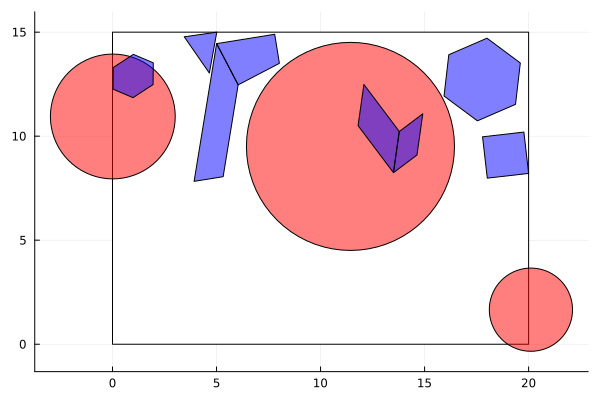

In [29]:
plota_solucao(circ_r,lista_rotacionada,L, W, xP, yP, theta_P, xL, yL, alpha_L, xC, yC)

# Perguntas interessantes

  - Como encontrar o _strip_ de lado mínimo? Ou o quadrado?
  - O que acontece quando a reta fica quase vertical?
  - Como fazer um ponto inicial melhor?

# Em ação!

Para ser usável por um leigo, precisamos

  - Uma interface com o usuário (usaremos o GeoGebra)
  - Definir os parâmetros de entrada
      - $W$ e $L$
      - Raios dos círculos
      - Vértices dos polígonos
      - Quantidades de cada um :(
  - Definir a saida (texto, imagem)

Para esse objetivo, criamos uma função `le_arquivo` que recebe um arquivo com as seguintes propriedades
  - Cada linha ou tem um raio, um polígono convexo ou um vazio
  - Um polígono irregular é definido por uma sequência de linhas de polígonos convexos seguida de um vazio
  - Cada coluna ou tem apenas o raio ou então tem as coordenadas de um vértice no formato `(xx.xxx, xx.xxx)`
  - As colunas são separadas por tabulações (`\t`)

Veja os arquivos `.csv` na pasta do GeoGebra

Também criamos a função

    resolve_o_problema(W, L, arquivo)

que recebe as dimensões do retângulo e o arquivo de itens. Devolve o desenho, mas o correto seria as coordenadas, para que o usuário faça alguma coisa com a resposta.

In [84]:
raios, P = le_arquivo("/tmp/ermac.csv");

In [85]:
display(raios)

3-element Vector{Any}:
 1.0
 2.0
 4.0

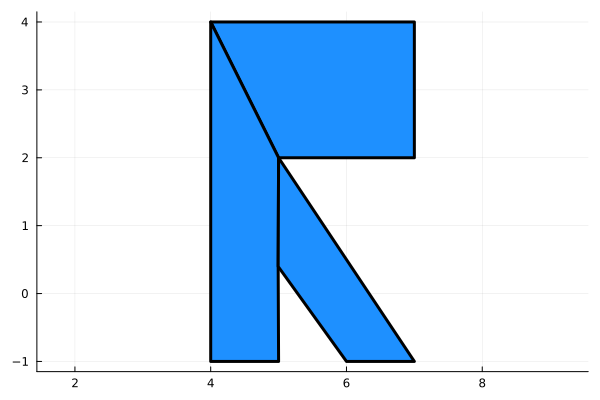

In [86]:
plot(uniao_poligonos(P[2]), c=:dodgerblue, lc=:black, lw=3, label=false, aspect_ratio=true)

In [ ]:
resolve_o_problema(20, 20, "/tmp/ermac.csv")